<a href="https://colab.research.google.com/github/izaymelissza/NLP-projekt-/blob/main/NLP_projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mentális egészségre fókuszáló sentiment elemzés**

## Adatok (dataset) betöltése

In [8]:
!pip install datasets

In [9]:
from datasets import load_dataset
import pandas as pd
from tqdm import tqdm

data = load_dataset("AhmedSSoliman/sentiment-analysis-for-mental-health-Combined-Data")
df = pd.DataFrame(data['train'])

print(df.head())

   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety


## Osztályeloszlás

Unique Labels: ['Anxiety' 'Normal' 'Depression' 'Suicidal' 'Stress' 'Bipolar'
 'Personality disorder']


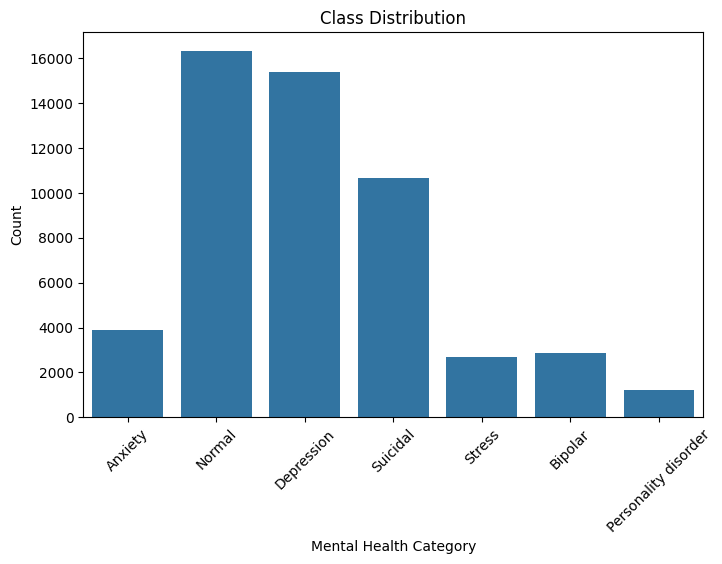

In [10]:
#import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Egyedi címkék megjelenítése
print("Unique Labels:", df['status'].unique())

# Osztályeloszlás vizualizációja
plt.figure(figsize=(8, 5))
sns.countplot(x='status', data=df)
plt.title('Class Distribution')
plt.xlabel('Mental Health Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Text cleaning

- Kisbetűsítés
- speciális karakterek eltávolítása
- Tokenizálás
- Stop szavak eltávolítása
- Lemmatizáció

In [15]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        text = ""
    # 1. Kisbetűsítés
    text = text.lower()
    # 2. Speciális karakterek eltávolítása
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # 3. Tokenizálás
    tokens = word_tokenize(text)
    # 4. Stop szavak eltávolítása
    text = [word for word in tokens if word not in stop_words]
    # 5. Lemmatizáció
    text = [lemmatizer.lemmatize(word) for word in tokens]
    # 6. Szavak visszaalakítása szöveggé
    return " ".join(text)

tqdm.pandas(desc="Text cleaning")
df['cleaned_statement'] = df['statement'].progress_apply(preprocess_text)

print(df[['statement', 'cleaned_statement']].head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
Text cleaning: 100%|██████████| 53043/53043 [01:04<00:00, 816.93it/s]

                                           statement  \
0                                         oh my gosh   
1  trouble sleeping, confused mind, restless hear...   
2  All wrong, back off dear, forward doubt. Stay ...   
3  I've shifted my focus to something else but I'...   
4  I'm restless and restless, it's been a month n...   

                                   cleaned_statement  
0                                         oh my gosh  
1  trouble sleeping confused mind restless heart ...  
2  all wrong back off dear forward doubt stay in ...  
3  ive shifted my focus to something else but im ...  
4  im restless and restless it been a month now b...  


## Modellépítés

In [16]:
from sklearn.model_selection import train_test_split

X = df['cleaned_statement']
y = df['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

TF-IDF

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

Logisztikus regresszió

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
model.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000))

## Kiértékelés

In [19]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
predictions = model.predict(X_test_tfidf)
print("Pontosság:", accuracy_score(y_test, predictions))
print("Report:\n", classification_report(y_test, predictions))

Pontosság: 0.7439909510792723
Report:
                       precision    recall  f1-score   support

             Anxiety       0.75      0.67      0.71       778
             Bipolar       0.81      0.62      0.70       575
          Depression       0.70      0.73      0.71      3081
              Normal       0.80      0.96      0.87      3270
Personality disorder       0.86      0.35      0.49       240
              Stress       0.70      0.39      0.50       534
            Suicidal       0.69      0.63      0.66      2131

            accuracy                           0.74     10609
           macro avg       0.76      0.62      0.66     10609
        weighted avg       0.74      0.74      0.73     10609



Konfúziós mátrix

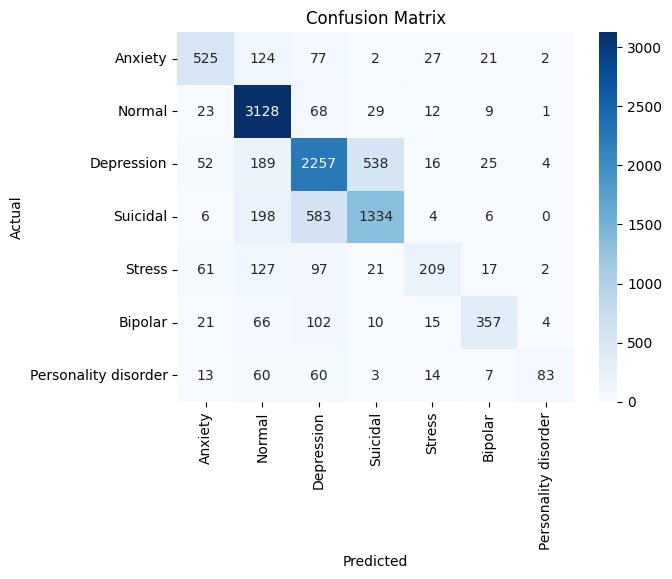

In [20]:
conf_matrix = confusion_matrix(y_test, predictions, labels=df['status'].unique())
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['status'].unique(), yticklabels=df['status'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Legfontosabb szavak

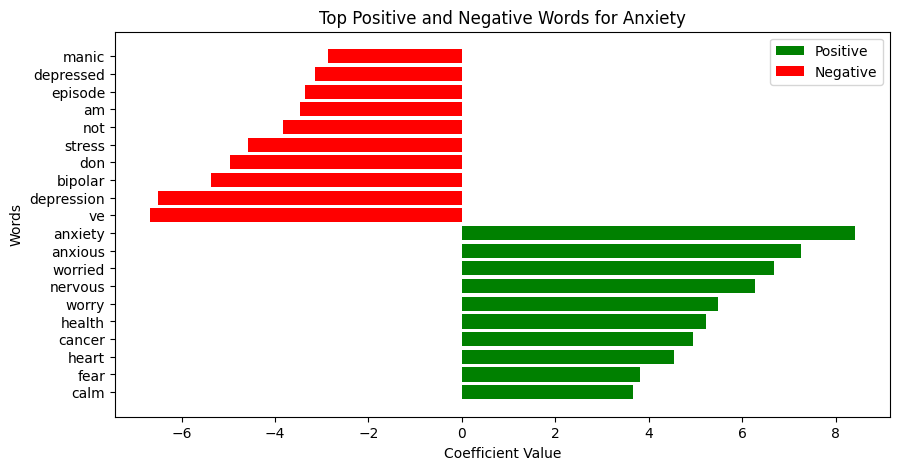

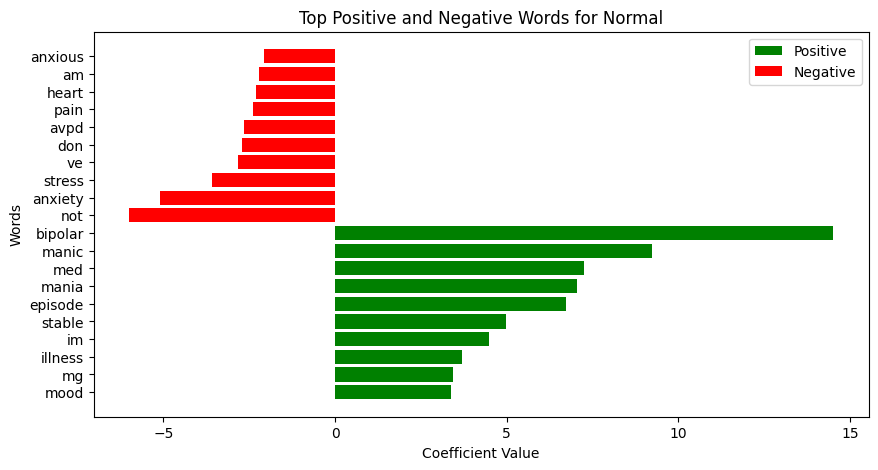

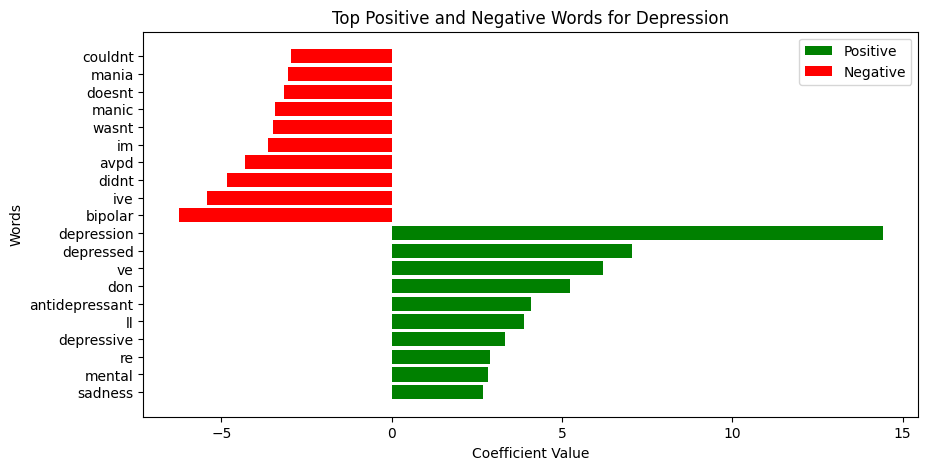

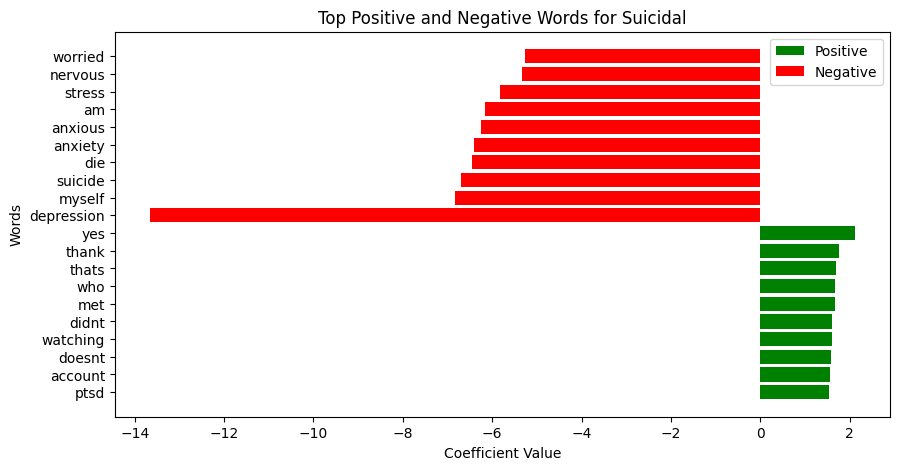

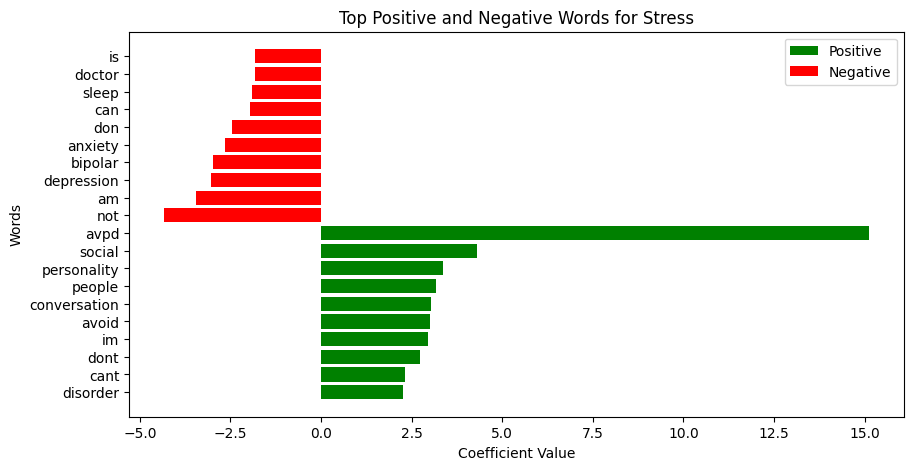

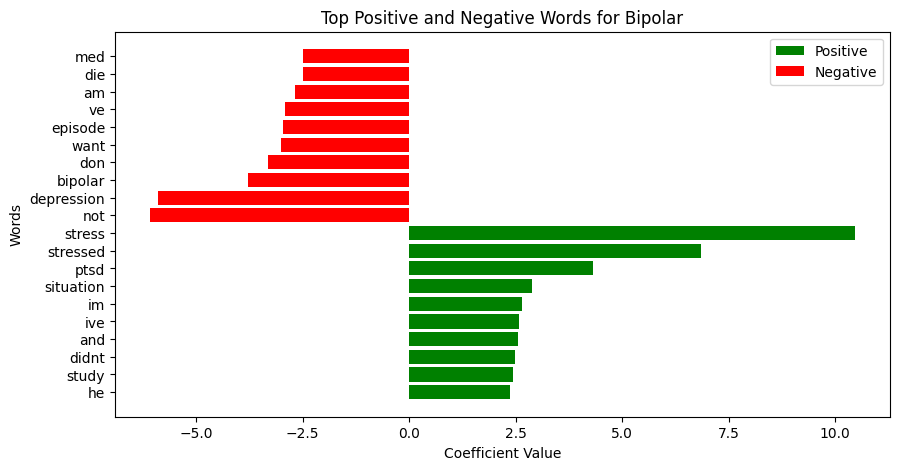

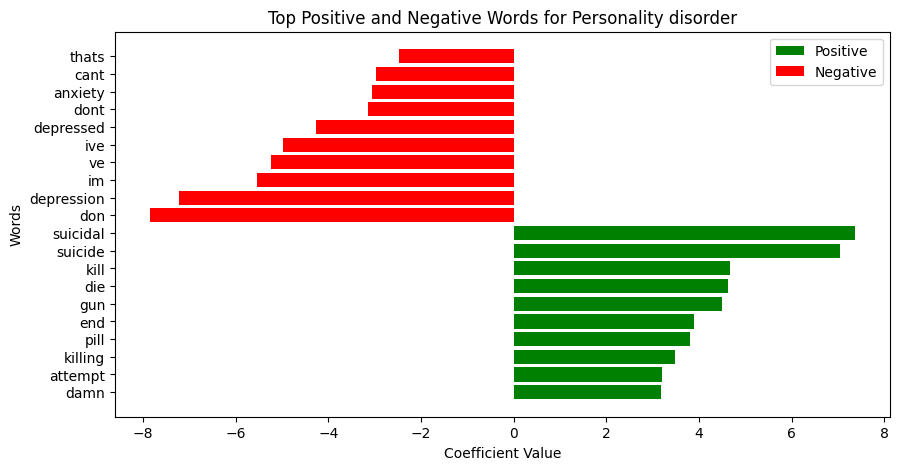

In [22]:
import numpy as np
feature_names = vectorizer.get_feature_names_out()
coefficients = model.estimators_
# Vizualizáció az egyes címkékhez
for i, label in enumerate(df['status'].unique()):
    top_indices = np.argsort(coefficients[i].coef_)[0][-10:]
    bottom_indices = np.argsort(coefficients[i].coef_)[0][:10]

    plt.figure(figsize=(10, 5))
    plt.barh([feature_names[j] for j in top_indices], coefficients[i].coef_[0][top_indices], color='green', label='Positive')
    plt.barh([feature_names[j] for j in bottom_indices], coefficients[i].coef_[0][bottom_indices], color='red', label='Negative')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Words')
    plt.title(f'Top Positive and Negative Words for {label}')
    plt.legend()
    plt.show()